In [13]:
!pip install category_encoders
!pip install texthero

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 238 kB 9.9 MB/s 
     |████████████████████████████████| 1.4 MB 7.6 MB/s 
     |████████████████████████████████| 10.4 MB 5.8 MB/s 
     |████████████████████████████████| 366 kB 3.4 MB/s 
     |████████████████████████████████| 24.2 MB 5.4 MB/s 
     |████████████████████████████████| 6.8 MB 11.1 MB/s 
     |████████████████████████████████| 82 kB 2.4 MB/s 
     |████████████████████████████████| 723 kB 15.3 MB/s 
     |████████████████████████████████| 293 kB 2.6 MB/s 
     |████████████████████████████████| 284 kB 3.4 MB/s 
     |████████████████████████████████| 1.1 MB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 9.9 MB/s 
     |████████████████████████████████| 117 kB 17.9 MB/s 
  Cr

In [34]:
import pandas as pd
import pathlib
import category_encoders as ce
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import texthero as hero
from texthero import preprocessing

from sklearn import metrics
from sklearn.model_selection import GroupKFold, KFold

import lightgbm as lgb

from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.decomposition import PCA
from gensim.models import word2vec
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import model_selection

In [35]:
DATA_DIR = pathlib.Path('/home/knikaido/work/atma8/data/')
OUTPUT_DIR = './sub20/'
train_csv_path = DATA_DIR / 'train.csv'
test_csv_path = DATA_DIR / 'test.csv'

In [36]:
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
whole_df = pd.concat([train_df, test_df], ignore_index=True)

In [37]:
train_column = train_df.columns

In [38]:
X_column = []
for s in train_column:
    if not'Sales' in s:
        X_column.append(s)

In [39]:
train_df_drop = train_df[X_column]

In [40]:
# User_Scoreの変換
def make_user_score(df):
    d = df['User_Score'].copy()
    d[d == 'tbd'] = 'nan'
    df.loc[:,'User_Score'] = d
    
    return df

In [41]:
train_df_drop = make_user_score(train_df_drop)
test_df = make_user_score(test_df)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [42]:
whole_df = pd.concat([train_df_drop, test_df], ignore_index=True)

In [43]:
year_mean = whole_df.groupby('Platform').mean()['Year_of_Release'].astype('int')
year_mean.name = 'Year_Mean'

In [44]:
# whole_df = pd.merge(whole_df, year_mean, on='Platform', how='left')
# whole_df['Year_of_Release'].fillna(whole_df['Year_Mean'], inplace=True)
# whole_df.drop('Year_Mean', axis=1, inplace=True)

# train_df_drop = whole_df.iloc[:len(train_df_drop), :]
# test_df = whole_df.iloc[len(train_df_drop):, :]


In [45]:
def add_pub_dev_info(df1, df2, tgt, col, func='count'):
    whole_df = pd.concat([df1, df2], ignore_index=True)
    plat_pivot = whole_df.pivot_table(index=tgt, columns=col, values='Name', aggfunc=func).reset_index()
    plat_pivot.fillna(0, inplace=True)

    n_ = 5
    pca = PCA(n_components=n_)
    plat_pca = pca.fit_transform(plat_pivot.iloc[:, 1:].values) 
    cols = [tgt[:2] +  '_' + col+'_pca_'+str(i) for i in range(n_)]
    plat_pca_df = pd.DataFrame(plat_pca, index=plat_pivot.iloc[:,0], columns=cols)
    whole_df = pd.merge(whole_df, plat_pca_df, on=tgt, how='left')

    df1 = whole_df.iloc[:len(df1), :]
    df2 = whole_df.iloc[len(df1):, :]
    return df1, df2

In [46]:
train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Publisher', 'Platform')
train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Publisher', 'Genre')
train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Publisher', 'Rating')
# train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Publisher', 'Critic_Score')
# train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Publisher', 'Critic_Count')
# train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Publisher', 'User_Score')
# train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Publisher', 'User_Count')

train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Developer', 'Platform')
train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Developer', 'Genre')
train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Developer', 'Rating')
# train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Developer', 'Critic_Score')
# train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Developer', 'Critic_Count')
# train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Developer', 'User_Score')
# train_df_drop, test_df = add_pub_dev_info(train_df_drop, test_df, 'Developer', 'User_Count')

train_df_drop

,Name,Platform,Year_of_Release,Genre,Publisher,Critic_Score,Critic_Count,User_Score,User_Count,Developer,...,De_Genre_pca_0,De_Genre_pca_1,De_Genre_pca_2,De_Genre_pca_3,De_Genre_pca_4,De_Rating_pca_0,De_Rating_pca_1,De_Rating_pca_2,De_Rating_pca_3,De_Rating_pca_4
0,LEGO Batman: The Videogame,Wii,2008.0,Action,Warner Bros. Interactive Entertainment,74.0,17.0,7.9,22.0,Traveller's Tales,...,11.001662,60.676705,-14.921881,1.765402,-6.857721,21.425117,10.486456,52.322374,-8.557706,-0.083993
1,LEGO Indiana Jones: The Original Adventures,Wii,2008.0,Action,LucasArts,78.0,22.0,6.6,28.0,Traveller's Tales,...,11.001662,60.676705,-14.921881,1.765402,-6.857721,21.425117,10.486456,52.322374,-8.557706,-0.083993
2,LEGO Batman: The Videogame,PSP,2008.0,Action,Warner Bros. Interactive Entertainment,73.0,5.0,7.4,10.0,Traveller's Tales,...,11.001662,60.676705,-14.921881,1.765402,-6.857721,21.425117,10.486456,52.322374,-8.557706,-0.083993
3,Combat,2600,1982.0,Action,Atari,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,LEGO Harry Potter: Years 5-7,Wii,2008.0,Action,Warner Bros. Interactive Entertainment,76.0,8.0,7.8,13.0,Traveller's Tales,...,11.001662,60.676705,-14.921881,1.765402,-6.857721,21.425117,10.486456,52.322374,-8.557706,-0.083993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8354,Stellaris,PC,2016.0,Strategy,Paradox Interactive,78.0,57.0,8,569.0,Paradox Development Studio,...,-1.257383,-1.275148,-0.316958,-0.340787,-0.374459,-2.262654,-0.232654,1.623968,-0.834035,-0.005679
8355,Total War Attila: Tyrants & Kings,PC,2016.0,Strategy,Koch Media,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8356,Brothers Conflict: Precious Baby,PSV,2017.0,Action,Idea Factory,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8357,Phantasy Star Online 2 Episode 4: Deluxe Package,PS4,2017.0,Role-Playing,Sega,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
# cols = 'Name_0'
# fig, ax = plt.subplots(figsize = (16, 6))

# sns.distplot(train_df_drop['Pu_Critic_Score_pca_0'].values, 
#              hist=True, rug=True, label='train',kde_kws=dict(linewidth=4))
# sns.distplot(test_df['Pu_Critic_Score_pca_0'].values, 
#              hist=True, rug=True, label='test', kde_kws=dict(linewidth=4))
# ax.set_title(f'Distribution for {cols}', fontsize=16)
# sns.despine(left=True, bottom=True)
# plt.legend()
# plt.show()

In [48]:
# train_df_drop

In [49]:
# plt.plot(train_df_drop['plat_pca_1'])
# plt.plot(train_df_drop['plat_pca_0'])
# plt.plot(train_df_drop['Publisher'])

In [50]:
# plt.plot(train_df_drop['Publisher'])

In [51]:
# train_df_drop

In [52]:
# Ratingの変換

In [53]:
def encode_label(train, test):
    cate_col = ['Rating', 'Platform', 'Genre']
    oe = ce.OrdinalEncoder(cols=cate_col, drop_invariant=True, handle_missing='return_nan')
    train.loc[:,cate_col] = oe.fit_transform(train[cate_col])
    test.loc[:,cate_col] = oe.transform(test[cate_col])
    return train, test

In [54]:
train_df_drop, test_df = encode_label(train_df_drop, test_df)

/home/user/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning:

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead



In [55]:
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace
                  ]

In [56]:
def translate_name(df1, df2):
    df = pd.concat([df1, df2])
    tif_vec = hero.tfidf(hero.clean(df['Name'], pipeline=custom_pipeline))
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Name'], pipeline=custom_pipeline)))
    tif_vec_l = []
    for i in range(len(tif_vec)):
        tif_vec_l.append(tif_vec.values[i])
    tif_vec_np = np.array(tif_vec_l)

#     km = KMeans(n_clusters=6, init='k-means++', n_init=10, max_iter=300, tol=1e-04, random_state=0)
#     y_km = km.fit_predict(tif_vec_np)
#     df['kmeans_name'] = y_km
    
    pca = PCA(n_components=30)
    tif_vec_pca = pca.fit_transform(tif_vec_np) 
#     tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 1000)
#     tif_vec_pca = tsne.fit_transform(tif_vec_np)
    
    for i in range(tif_vec_pca.shape[1]):
        c_ = 'Name_' + str(i)
        df[c_] = tif_vec_pca[:, i]
    df1 = df.iloc[:len(df1), :]
    df2 = df.iloc[len(df1):, :]
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Developer'], pipeline=custom_pipeline)))
#     n_pca_l = []
#     for i in range(len(n_pca)):
#         n_pca_l.append(n_pca.values[i])
#     n_pca_np = np.array(n_pca_l)
#     df['Developer_0'] = n_pca_np[:, 0]
#     df['Developer_1'] = n_pca_np[:, 1]
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Publisher'], pipeline=custom_pipeline)))
#     n_pca_l = []
#     for i in range(len(n_pca)):
#         n_pca_l.append(n_pca.values[i])
#     n_pca_np = np.array(n_pca_l)
#     df['Publisher_0'] = n_pca_np[:, 0]
#     df['Publisher_1'] = n_pca_np[:, 1]
    
    return df1, df2

In [57]:
train_df_drop, test_df = translate_name(train_df_drop, test_df)


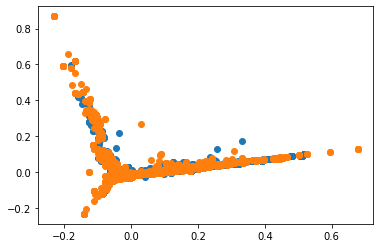

In [58]:
plt.scatter(train_df_drop['Name_0'].values, train_df_drop['Name_1'].values)
plt.scatter(test_df['Name_0'].values, test_df['Name_1'].values)

In [59]:
def translate_name_wav2vec(df1, df2):
    df = pd.concat([df1, df2])
    C_Name = hero.clean(df['Name'], pipeline=custom_pipeline)
    sentences = []
    for sentence in C_Name:
        data = sentence.split()
        sentences.append(data)
    model = word2vec.Word2Vec(sentences,
                              size=200,
                              min_count=1,
                              window=5,
                              iter=20,
                              sg = 0)
    w_vec = []
    for sentence in C_Name:
        data = sentence.split()
        tmp = np.zeros(200)
        for d in data:
            tmp += model[d]
        w_vec.append(tmp)
    w_vec = np.array(w_vec)
    
    pca = PCA(n_components=30)
    w_vec_pca = pca.fit_transform(w_vec) 
#     tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 1000)
#     w_vec_pca = tsne.fit_transform(w_vec_pca)
    for i in range(w_vec_pca.shape[1]):
        c_ = 'W_Name_' + str(i)
        df[c_] = w_vec_pca[:, i]
        
        
        
#     pca = PCA(n_components=10)
#     w_vec_pca = pca.fit_transform(w_vec)
    
#     df['Name_0'] = w_vec_pca[:, 0]
#     df['Name_1'] = w_vec_pca[:, 1]
#     df['Name_2'] = w_vec_pca[:, 2]
#     df['Name_3'] = w_vec_pca[:, 3]
#     df['Name_4'] = w_vec_pca[:, 4]
#     df['Name_5'] = w_vec_pca[:, 5]
#     df['Name_6'] = w_vec_pca[:, 6]
#     df['Name_7'] = w_vec_pca[:, 7]
#     df['Name_8'] = w_vec_pca[:, 8]
#     df['Name_9'] = w_vec_pca[:, 9]
    df1 = df.iloc[:len(df1), :]
    df2 = df.iloc[len(df1):, :]
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Developer'], pipeline=custom_pipeline)))
#     n_pca_l = []
#     for i in range(len(n_pca)):
#         n_pca_l.append(n_pca.values[i])
#     n_pca_np = np.array(n_pca_l)
#     df['Developer_0'] = n_pca_np[:, 0]
#     df['Developer_1'] = n_pca_np[:, 1]
    
#     n_pca = hero.pca(hero.tfidf(hero.clean(df['Publisher'], pipeline=custom_pipeline)))
#     n_pca_l = []
#     for i in range(len(n_pca)):
#         n_pca_l.append(n_pca.values[i])
#     n_pca_np = np.array(n_pca_l)
#     df['Publisher_0'] = n_pca_np[:, 0]
#     df['Publisher_1'] = n_pca_np[:, 1]
    
    return df1, df2

In [60]:
train_df_drop, test_df = translate_name_wav2vec(train_df_drop, test_df)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).



In [61]:
drop_c = ['Name', 'Publisher', 'Developer']
train_df_drop.drop(drop_c, axis=1, inplace=True)
test_df.drop(drop_c, axis=1, inplace=True)
train_df_drop

,Platform,Year_of_Release,Genre,Critic_Score,Critic_Count,User_Score,User_Count,Rating,Pu_Platform_pca_0,Pu_Platform_pca_1,...,W_Name_20,W_Name_21,W_Name_22,W_Name_23,W_Name_24,W_Name_25,W_Name_26,W_Name_27,W_Name_28,W_Name_29
0,1.0,2008.0,1.0,74.0,17.0,7.9,22.0,1.0,48.983372,-21.987508,...,-0.435896,0.474533,-0.421494,0.297476,-0.165344,0.167367,-0.150246,0.354408,-0.118438,-0.321831
1,1.0,2008.0,1.0,78.0,22.0,6.6,28.0,1.0,19.845629,2.303901,...,-0.804864,0.386908,-0.387094,0.025687,-0.235922,0.184963,0.380093,0.059220,-0.177654,-0.163292
2,2.0,2008.0,1.0,73.0,5.0,7.4,10.0,1.0,48.983372,-21.987508,...,-0.435896,0.474533,-0.421494,0.297476,-0.165344,0.167367,-0.150246,0.354408,-0.118438,-0.321831
3,3.0,1982.0,1.0,NaN,NaN,NaN,NaN,NaN,87.992511,-5.615959,...,0.193091,0.215967,-0.039467,0.026733,0.093412,-0.142091,0.212932,0.034845,-0.044215,-0.057555
4,1.0,2008.0,1.0,76.0,8.0,7.8,13.0,1.0,48.983372,-21.987508,...,-2.282578,1.743831,0.443483,-0.693053,-1.663853,0.326316,0.743637,-1.055404,0.430171,-0.051415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8354,9.0,2016.0,12.0,78.0,57.0,8,569.0,NaN,-3.029079,-0.973596,...,-0.086449,0.087442,0.152586,0.040097,-0.018344,-0.037942,-0.011966,0.011072,0.003218,-0.031636
8355,9.0,2016.0,12.0,NaN,NaN,NaN,NaN,NaN,-3.591453,-0.481136,...,0.053686,0.815736,-0.736053,-0.189338,-0.136993,-0.359778,0.765118,0.477886,-0.465570,-0.201198
8356,14.0,2017.0,1.0,NaN,NaN,NaN,NaN,NaN,23.709706,23.341467,...,0.070454,-0.099854,-0.124278,-0.325046,0.131111,-0.168230,-0.008650,0.017083,-0.069660,-0.189478
8357,30.0,2017.0,8.0,NaN,NaN,NaN,NaN,NaN,146.907780,-5.172567,...,-0.045519,0.200847,0.498450,-0.313994,0.585391,-0.315115,-0.360135,-0.308232,-0.163178,-0.298279


In [62]:
train_df_drop = train_df_drop.astype('float64')
test_df = test_df.astype('float64')

In [63]:
X = train_df_drop
y = train_df['Global_Sales'].astype('float64')
groups = train_df['Publisher']

In [64]:
def create_folds(data, target_col):
    num_bins = np.int(1 + np.log2(len(data)))
    bins = pd.cut(
        data[target_col],
        bins=num_bins,
        labels=False
    )
    kf = model_selection.StratifiedKFold(n_splits=10)
    fold_ids = list(kf.split(X=data, y=bins.values))
    return fold_ids

fold_ids = create_folds(train_df, "Global_Sales")

/home/user/.local/lib/python3.6/site-packages/sklearn/model_selection/_split.py:672: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=10.



In [65]:

# kfoldの分割数
k = 10
# kf = KFold(n_splits=k, shuffle=True, random_state=0)
# kf = GroupKFold(n_splits=k)

lgbm_params = {'objective': 'regression',
              "metric":"rmse",
               'max_dapth': 8,
              "learning_rate": 0.01,
               'colsample_bytree': 0.8}

rmsle_train_list = []
rmsle_eval_list = []

pred_test_np = np.zeros([k, len(test_df)])
oof_pred = np.zeros_like(y, dtype=np.float)

# kfoldで分割
for i, (train_index, test_index) in enumerate(fold_ids):

    X_train = X.iloc[train_index]
    y_train = y.iloc[train_index]
    X_test = X.iloc[test_index]
    y_test = y.iloc[test_index]
    y_train = np.log1p(y_train)
    y_test = np.log1p(y_test)

    # データセットを生成する
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test)

    # 学習
    model = lgb.train(lgbm_params,
                        lgb_train,
                        valid_sets=[lgb_eval, lgb_train],
                        num_boost_round=10000,
                        early_stopping_rounds=1000,
                        verbose_eval=200)

    predict_train = model.predict(X_train, num_iteration=model.best_iteration)
    predict_eval = model.predict(X_test, num_iteration=model.best_iteration)
    oof_pred[test_index] = predict_eval
    
    rmsle_train = np.sqrt(mean_squared_error(y_train, predict_train))
    rmsle_eval = np.sqrt(mean_squared_error(y_test, predict_eval))
    print(f'RMSLE_train: {rmsle_train}, RMSLE_eval: {rmsle_eval}')
    rmsle_train_list.append(rmsle_train)
    rmsle_eval_list.append(rmsle_eval)
    
    pred_test_np[i] = model.predict(test_df, num_iteration=model.best_iteration)
    
print(f'RMSLE_train_mean: {np.mean(rmsle_train_list)}, RMSLE_eval_mean: {np.mean(rmsle_eval_list)}')

    # predict_probaが0.5以上なら1とする
#     predict = [0 if i < 0.5 else 1 for i in predict_proba]

#     auc, precision, recall = get_evaluate(y_test, predict)

#     print('AUC:{}, precision:{}, recall:{}'.format(auc, precision, recall))

#     auc_list.append(auc)
#     precision_list.append(precision)
#     recall_list.append(recall)

# # kfoldの平均値を取得
# print('Kfold平均 AUC:{}, precision:{}, recall:{}'.format(np.mean(auc_list), 
#                                                          np.mean(precision_list), 
#                                                          np.mean(recall_list)))

Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 0.871908	valid_0's rmse: 1.17426
[400]	training's rmse: 0.743747	valid_0's rmse: 1.15148
[600]	training's rmse: 0.67163	valid_0's rmse: 1.15089
[800]	training's rmse: 0.620177	valid_0's rmse: 1.15055
[1000]	training's rmse: 0.578498	valid_0's rmse: 1.15328
[1200]	training's rmse: 0.543096	valid_0's rmse: 1.15489
[1400]	training's rmse: 0.51251	valid_0's rmse: 1.15577
Early stopping, best iteration is:
[484]	training's rmse: 0.709384	valid_0's rmse: 1.15008
RMSLE_train: 0.709384281958469, RMSLE_eval: 1.150075847582633
Training until validation scores don't improve for 1000 rounds
[200]	training's rmse: 0.873929	valid_0's rmse: 1.05341
[400]	training's rmse: 0.749191	valid_0's rmse: 1.00409
[600]	training's rmse: 0.680723	valid_0's rmse: 0.989233
[800]	training's rmse: 0.630611	valid_0's rmse: 0.982161
[1000]	training's rmse: 0.590365	valid_0's rmse: 0.97815
[1200]	training's rmse: 0.554888	valid_0's rm

In [66]:
print(np.sqrt(mean_squared_error(np.log1p(y), oof_pred)))

0.9154261096271142


In [67]:
oof_df = pd.DataFrame(oof_pred, columns=['Global_Sales'])
oof_df.to_csv(OUTPUT_DIR + "oof20.csv", index = False)

In [68]:
pred_test_mean = np.mean(pred_test_np, axis=0)
pred_test_exp = np.expm1(pred_test_mean)

In [69]:
sub = pd.read_csv(DATA_DIR / 'atmaCup8_sample-submission.csv')
sub['Global_Sales'] = pred_test_exp
sub.to_csv(OUTPUT_DIR + "sub20.csv", index = False)

In [70]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    model = models
#     for i, model in enumerate(models):
    _df = pd.DataFrame()
    _df['feature_importance'] = model.feature_importance(importance_type='gain')
    _df['column'] = feat_train_df.columns
    _df['fold'] = i + 1
    feature_importance_df = pd.concat([feature_importance_df, _df], axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(max(6, len(order) * .4), 7))
    sns.boxenplot(data=feature_importance_df, x='column', y='feature_importance', order=order, ax=ax, palette='viridis')
    ax.tick_params(axis='x', rotation=90)
    ax.grid()
    fig.tight_layout()
    return fig, ax

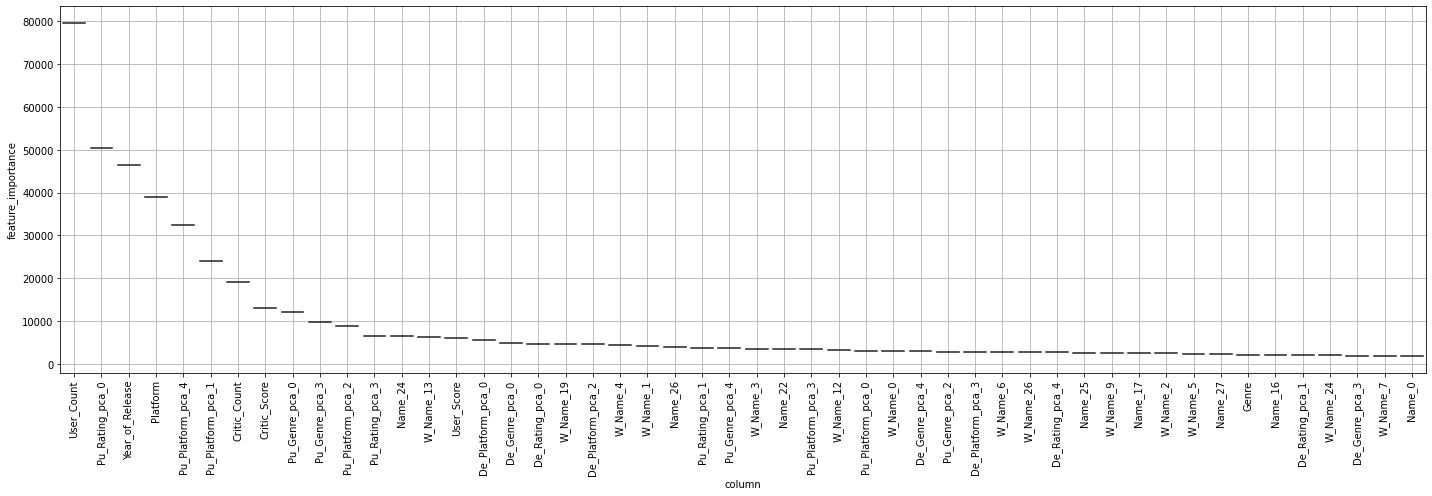

In [71]:
fig, ax = visualize_importance(model, X)


In [72]:
importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=train_df_drop.columns, columns=['importance'])
importance.sort_values(['importance'])

,importance
Name_2,323.877692
Pu_Genre_pca_1,496.322214
Name_7,515.143147
De_Rating_pca_3,518.100210
De_Genre_pca_1,616.086339
...,...
Pu_Platform_pca_4,32338.678168
Platform,38917.579210
Year_of_Release,46552.477817
Pu_Rating_pca_0,50343.438889


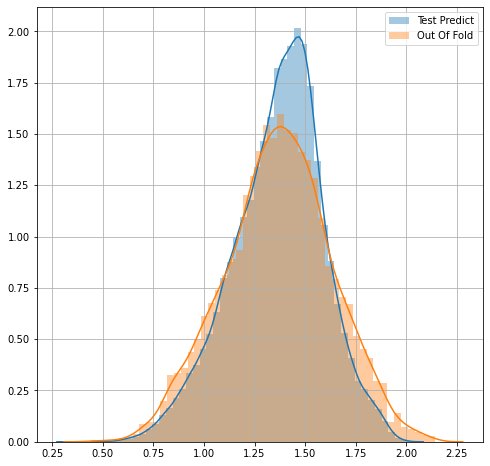

In [73]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.distplot(np.log1p(pred_test_np), label='Test Predict')
sns.distplot(np.log1p(oof_pred), label='Out Of Fold')
ax.legend()
ax.grid()

In [74]:
train_df_drop.corr().style.background_gradient(axis=None)